In [18]:
import math
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
import sys
import copy
import itertools
from matplotlib.ticker import MaxNLocator
import csv

BASE_PATH = Path.cwd().parent
sys.path.append(str(BASE_PATH))

from model.sample_ballots import get_data, get_positions, fit_gmm, get_samples, N_VOTERS, PARTIES, EMISSION_DIST, PARTY_IDS, ELECTION_YEAR, ATTRIBUTES
from model.social_choice_functions import pluralityVote, BordaCount, instantRunoffVote, CopelandRule

**Sample initial profile**

In [9]:
N_VOTERS = 1000
df = get_data(BASE_PATH, PARTY_IDS)
party_positions = get_positions(df, ATTRIBUTES)
gmm = fit_gmm(party_positions, PARTIES, EMISSION_DIST)
init_sample_points, init_sample_cluster_labels, init_sample_ballots = get_samples(gmm, party_positions, N_VOTERS)

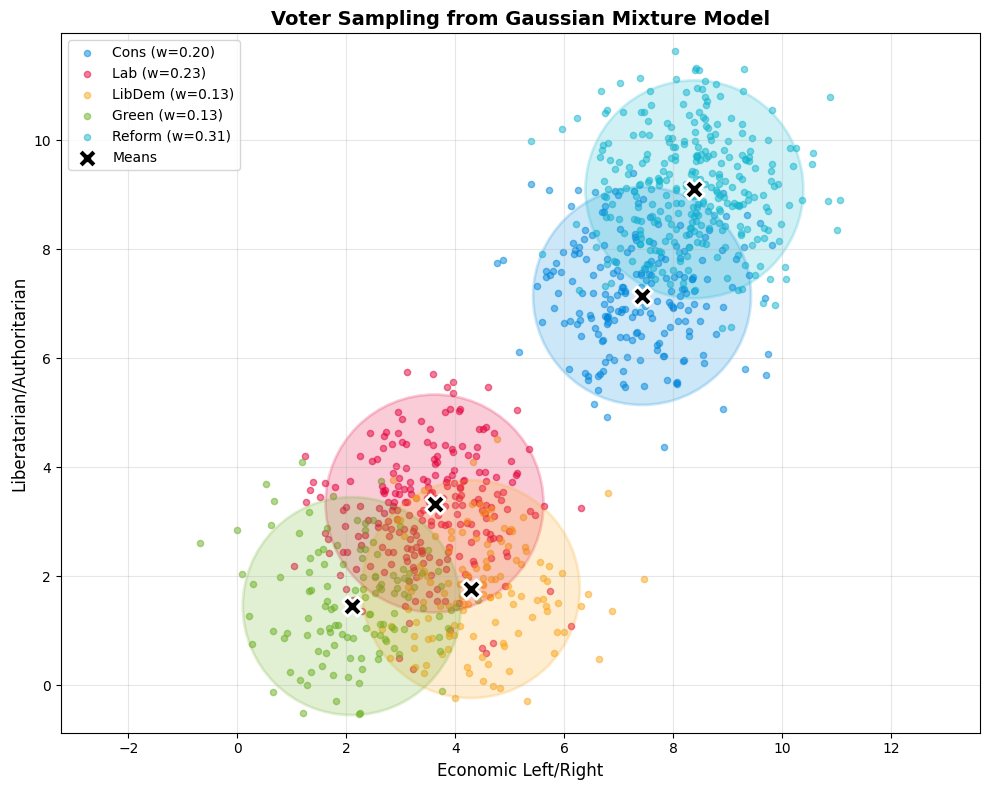

In [10]:
# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot samples colored by component
colors = ["#0087DC", "#E4003B", "#FAA61A", "#6AB023", "#12B6CF"]
scatter_plots = []

for i in range(len(PARTIES)):
    mask = init_sample_cluster_labels == i
    scatter = ax.scatter(init_sample_points[mask, 0], init_sample_points[mask, 1], 
              c=colors[i], alpha=0.5, s=20, 
              label=f'{PARTIES[i]} (w={gmm.weights_[i]:.2f})')
    scatter_plots.append((scatter, mask))

# Plot means
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
          c='black', s=200, marker='X', 
          edgecolors='white', linewidths=2,
          label='Means', zorder=5)

# Draw confidence circles (2 standard deviations)
for i in range(len(PARTIES)):
    radius = 2 * np.sqrt(gmm.covariances_[i])  # 2 std devs
    
    circle = Circle(gmm.means_[i], radius,
                   facecolor=colors[i], alpha=0.2, 
                   edgecolor=colors[i], linewidth=2)
    ax.add_patch(circle)

# Create annotation for hover
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w", alpha=0.9),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# Hover function
def on_hover(event):
    if event.inaxes == ax:
        # Check each scatter plot
        for i, scatter in enumerate(scatter_plots):
            cont, ind = scatter.contains(event)
            if cont:
                # Get the index in the full samples array
                mask = init_sample_cluster_labels == i
                indices = np.where(mask)[0]
                idx = indices[ind["ind"][0]]
                
                # Update annotation
                x, y = init_sample_points[idx]
                annot.xy = (x, y)
                text = f'{PARTIES[i]} \nPosition: ({x:.2f}, {y:.2f})\nValue: {init_sample_ballots[idx]}'
                annot.set_text(text)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
        
        # If not hovering over any point, hide annotation
        if annot.get_visible():
            annot.set_visible(False)
            fig.canvas.draw_idle()

# Connect the hover event
fig.canvas.mpl_connect("motion_notify_event", on_hover)

ax.set_xlabel('Economic Left/Right', fontsize=12)
ax.set_ylabel('Liberatarian/Authoritarian', fontsize=12)
ax.set_title('Voter Sampling from Gaussian Mixture Model', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

**Add manipulators**

In [11]:
def compute_weighted_distance_utility(
    voter_position: np.array, # shape: (d,)
    party_positions: np.ndarray,    # shape: (M, d)
    voter_weights: np.ndarray = np.ones(len(ATTRIBUTES)) / len(ATTRIBUTES) # shape: (d,), default is uniform distribution
):
    """
    Returns utility matrix of shape (N, M)
    """
    d = voter_position.shape[0]
    M = party_positions.shape[0]

    utilities = np.zeros((M))

    diff = party_positions - voter_position # (d,)
    utilities = -np.sum(voter_weights * diff**2, axis=1)

    return utilities


In [12]:
print(init_sample_ballots)
total_prefer_labour_to_reform = 0
for ballot in init_sample_ballots:
    if ballot.index(1) < ballot.index(4):
        total_prefer_labour_to_reform += 1

print(total_prefer_labour_to_reform)

[[0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 1, 2, 4, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 1, 4, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 1, 4, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [4, 0, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 3], [4, 0, 1, 2, 3], [0, 4, 1, 2, 

**Analyse winners and scores under different systems**

In [13]:
# Break ties according to fixed ordering: Conservative > Labour > LibDem > Green > Reform

def getWinner(winners, tie_break_ordering=list(range(len(PARTIES)))):
    if isinstance(winners, list):
        for alt in tie_break_ordering:
            if alt in winners:
                return alt
    return winners


SCFs = [pluralityVote, BordaCount, instantRunoffVote, CopelandRule]
SCF_labels = ["Plurality vote", "Borda count", "Instant runoff vote", "Copeland rule"]

n_alts = len(PARTIES)

base_profile = tuple(tuple(b) for b in init_sample_ballots)

for SCF, label in zip(SCFs, SCF_labels):

    print("\n" + label + ":")
    init_winner = getWinner(SCF(base_profile, n_alts, print_scores=True))
    print("Winner:", PARTIES[init_winner])


Plurality vote:
Plurality scores: [226, 200, 156, 136, 282]
Winner: Reform

Borda count:
Borda scores: [2262, 2568, 2041, 1336, 1793]
Winner: Lab

Instant runoff vote:
round totals: {0: 226, 1: 200, 2: 156, 3: 136, 4: 282}
round totals: {0: 226, 1: 251, 2: 241, 4: 282}
round totals: {1: 261, 2: 241, 4: 498}
round totals: {1: 502, 4: 498}
Winner: Lab

Copeland rule:
Majority Matrix: 
[0, 508, 510, 526, 718]
[492, 0, 759, 815, 502]
[490, 241, 0, 815, 495]
[474, 185, 185, 0, 492]
[282, 498, 505, 508, 0]
Copeland scores: [4, 2, -2, -4, 0]
Winner: Cons


**Add Manipulators**


In [14]:
total_data = {}

# Iterate through each SCF
for SCF, label in zip(SCFs, SCF_labels):

    print("\n" + label + ":")

    init_winner = getWinner(SCF(base_profile, n_alts))
    print("winner:", PARTIES[init_winner])

    total_data[label] = []

    # Iterate through each mean party position, excluding winner
    for alt in range(n_alts):

        if alt == init_winner:
            total_data[label].append([])
            continue

        df = pd.DataFrame()

        sincere_position = party_positions[alt]
        utilities = compute_weighted_distance_utility(
            sincere_position,
            party_positions
        )

        sincere_ballot = tuple(np.argsort(-utilities).tolist())

        print("utilities:", utilities)
        print("sincere ballot:", sincere_ballot)

        # Find sincere ballot threshold

        augmented_profile = list(base_profile)   # working list
        print("Initial augmented profile size (should be 1000):", len(augmented_profile))
        winner = init_winner

        utilities_of_additions = []
        num_added_ballots = 0

        while winner != sincere_ballot[0]:
            augmented_profile.append(sincere_ballot)
            winner = getWinner(SCF(augmented_profile, n_alts))
            utilities_of_additions.append(utilities[winner])
            num_added_ballots += 1

        df["sincere"] = utilities_of_additions
        max_added_ballots = num_added_ballots

        print("needed sincere ballots:", max_added_ballots)

        # Tactical ballots search

        for ballot in itertools.permutations(list(range(n_alts))):

            if ballot == sincere_ballot:
                continue

            augmented_profile = list(base_profile)
            utilities_of_additions = []

            for _ in range(max_added_ballots):
                augmented_profile.append(ballot)
                winner = getWinner(SCF(augmented_profile, n_alts))
                utilities_of_additions.append(utilities[winner])

            df[str(ballot)] = utilities_of_additions

        total_data[label].append(df)



Plurality vote:
winner: Reform
utilities: [ -0.         -14.51247083 -19.41609944 -30.40114672  -2.37631038]
sincere ballot: (0, 4, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 56


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-14.51247083  -0.          -1.45691594  -2.927225   -28.00291966]
sincere ballot: (1, 2, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 82


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-19.41609944  -1.45691594  -0.          -2.43731564 -35.3418472 ]
sincere ballot: (2, 1, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 126


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-30.40114672  -2.927225    -2.43731564  -0.         -49.03631755]
sincere ballot: (3, 2, 1, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 146


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 


Borda count:
winner: Lab
utilities: [ -0.         -14.51247083 -19.41609944 -30.40114672  -2.37631038]
sincere ballot: (0, 4, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 153


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-19.41609944  -1.45691594  -0.          -2.43731564 -35.3418472 ]
sincere ballot: (2, 1, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 528


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-30.40114672  -2.927225    -2.43731564  -0.         -49.03631755]
sincere ballot: (3, 2, 1, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 706


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [ -2.37631038 -28.00291966 -35.3418472  -49.03631755  -0.        ]
sincere ballot: (4, 0, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 470


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 


Instant runoff vote:
winner: Lab
utilities: [ -0.         -14.51247083 -19.41609944 -30.40114672  -2.37631038]
sincere ballot: (0, 4, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 57


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-19.41609944  -1.45691594  -0.          -2.43731564 -35.3418472 ]
sincere ballot: (2, 1, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 20


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-30.40114672  -2.927225    -2.43731564  -0.         -49.03631755]
sincere ballot: (3, 2, 1, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 133


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [ -2.37631038 -28.00291966 -35.3418472  -49.03631755  -0.        ]
sincere ballot: (4, 0, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 4


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 


Copeland rule:
winner: Cons
utilities: [-14.51247083  -0.          -1.45691594  -2.927225   -28.00291966]
sincere ballot: (1, 2, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 17


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-19.41609944  -1.45691594  -0.          -2.43731564 -35.3418472 ]
sincere ballot: (2, 1, 3, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 519


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [-30.40114672  -2.927225    -2.43731564  -0.         -49.03631755]
sincere ballot: (3, 2, 1, 0, 4)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 631


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

utilities: [ -2.37631038 -28.00291966 -35.3418472  -49.03631755  -0.        ]
sincere ballot: (4, 0, 1, 2, 3)
Initial augmented profile size (should be 1000): 1000
needed sincere ballots: 437


C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(ballot)] = utilities_of_additions
C:\Users\dchal\AppData\Local\Temp\ipykernel_25684\3698733323.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [ ]:
print(total_data)

{'Plurality vote': [    sincere  (0, 1, 2, 3, 4)  (0, 1, 2, 4, 3)  (0, 1, 3, 2, 4)  \
0  -2.37631         -2.37631         -2.37631         -2.37631   
1  -2.37631         -2.37631         -2.37631         -2.37631   
2  -2.37631         -2.37631         -2.37631         -2.37631   
3  -2.37631         -2.37631         -2.37631         -2.37631   
4  -2.37631         -2.37631         -2.37631         -2.37631   
5  -2.37631         -2.37631         -2.37631         -2.37631   
6  -2.37631         -2.37631         -2.37631         -2.37631   
7  -2.37631         -2.37631         -2.37631         -2.37631   
8  -2.37631         -2.37631         -2.37631         -2.37631   
9  -2.37631         -2.37631         -2.37631         -2.37631   
10 -2.37631         -2.37631         -2.37631         -2.37631   
11 -2.37631         -2.37631         -2.37631         -2.37631   
12 -2.37631         -2.37631         -2.37631         -2.37631   
13 -2.37631         -2.37631         -2.37631         -2

AttributeError: 'dict' object has no attribute 'to_csv'

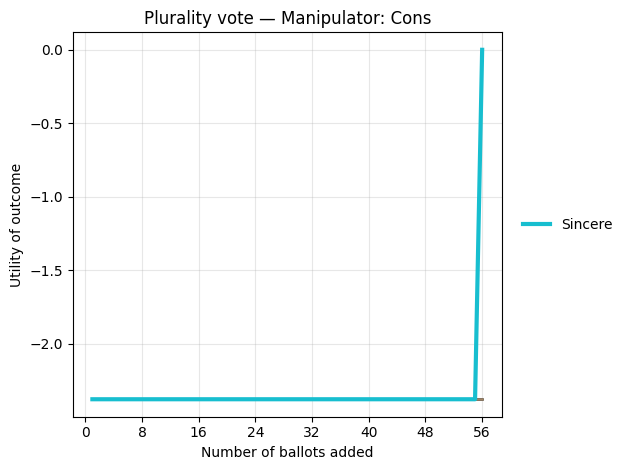

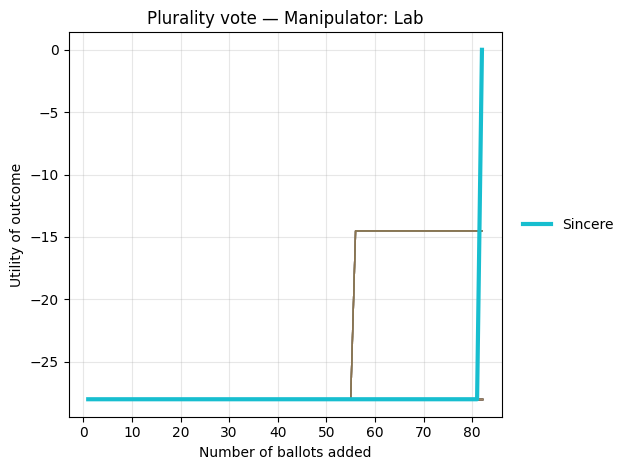

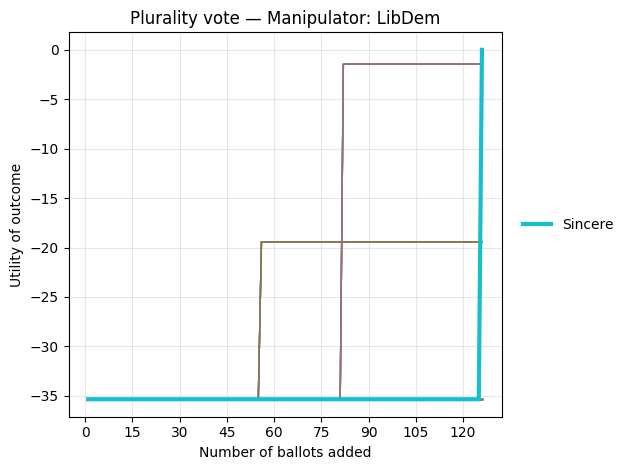

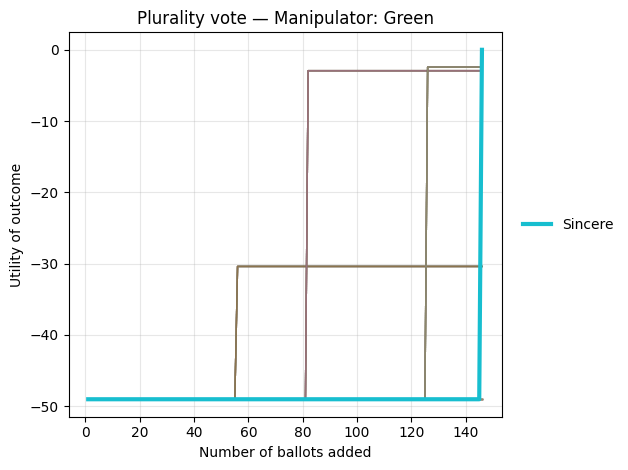

Winner under Plurality vote is Reform


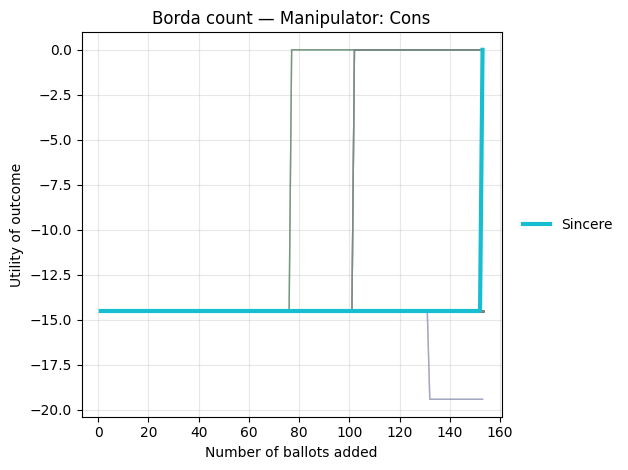

Winner under Borda count is Lab


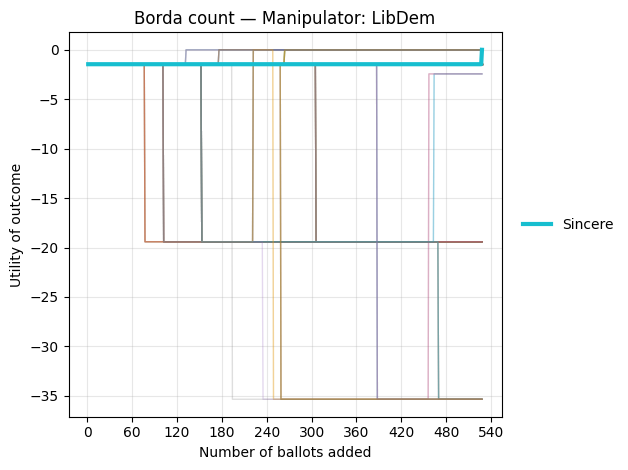

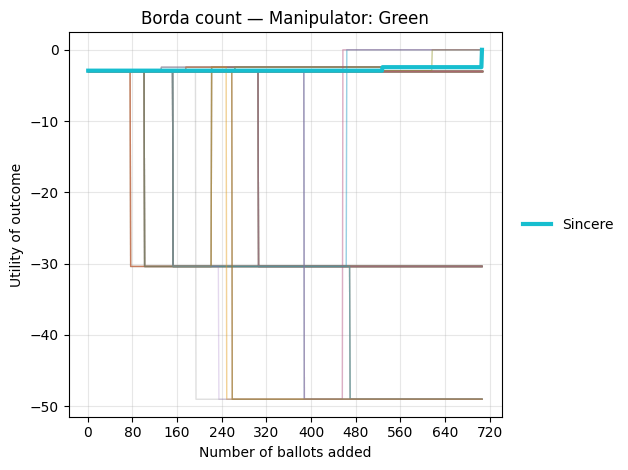

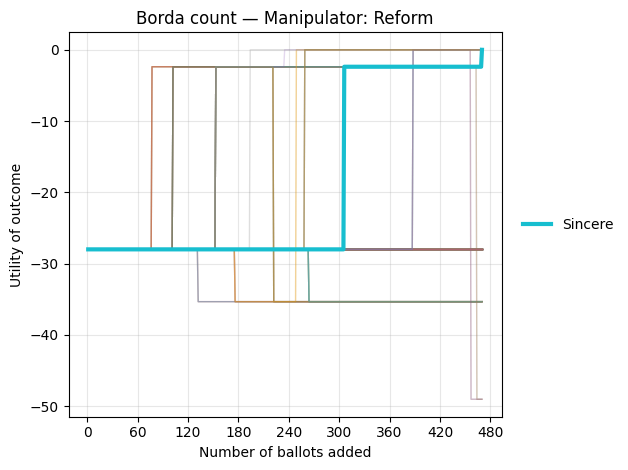

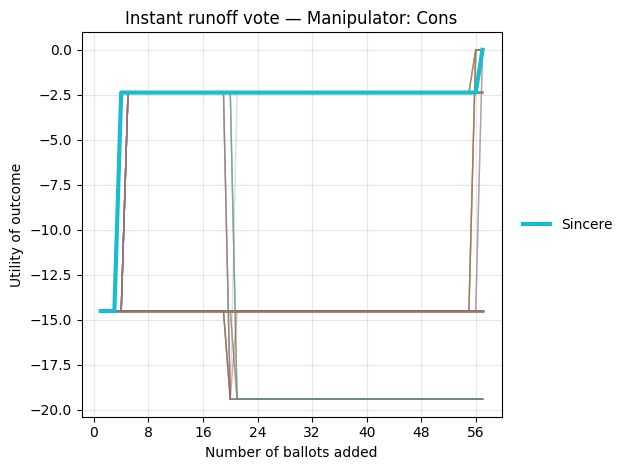

Winner under Instant runoff vote is Lab


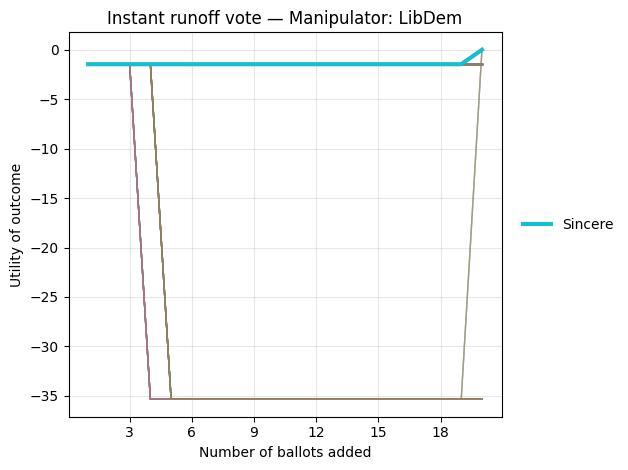

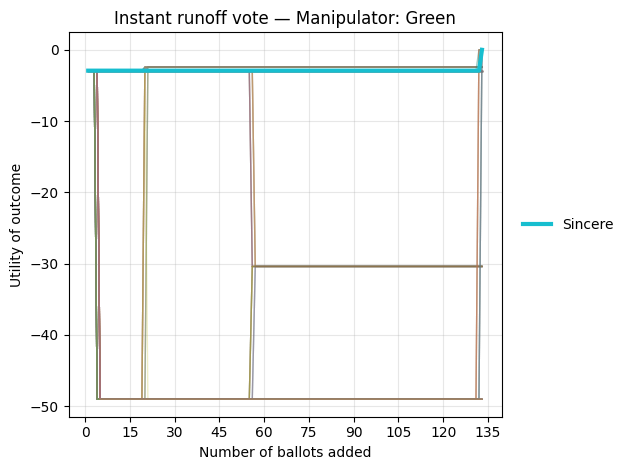

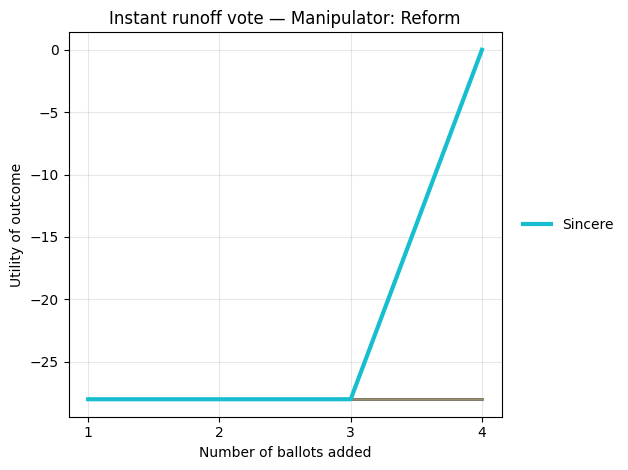

Winner under Copeland rule is Cons


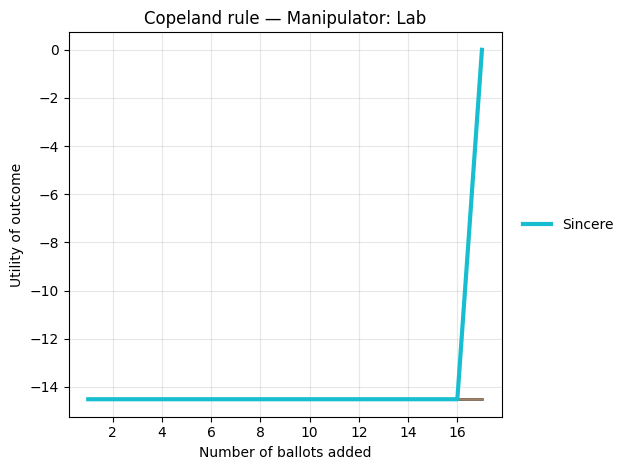

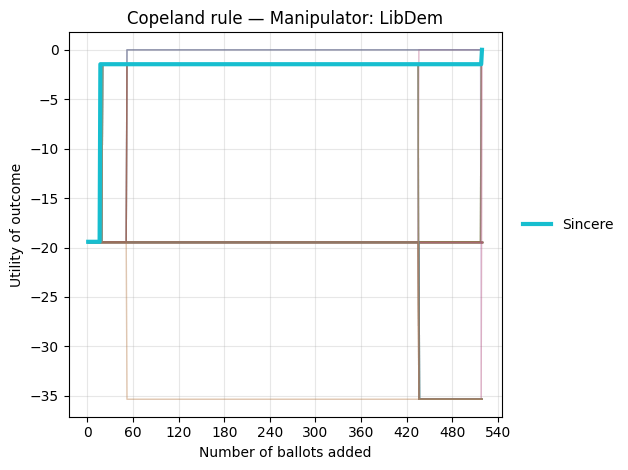

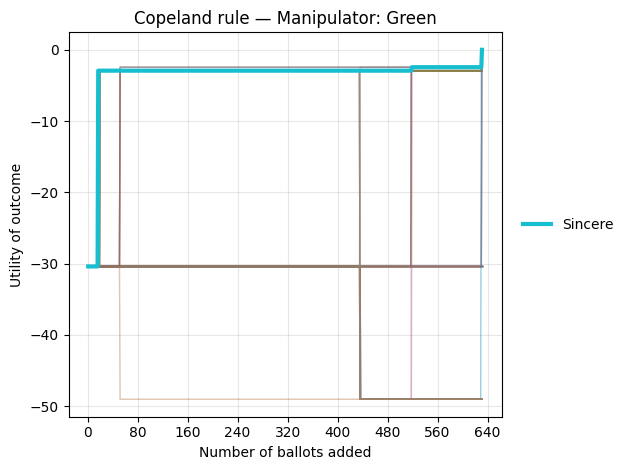

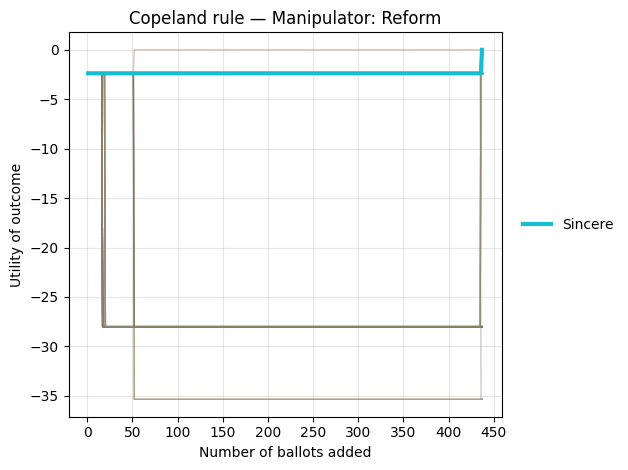

In [16]:
for scf_label, df_list in total_data.items():

    for alt, df in enumerate(df_list):

        if isinstance(df, list) or df.empty:
            print(f"Winner under {scf_label} is {PARTIES[alt]}")
            continue

        plt.figure()

        x = range(1, len(df) + 1)

        # Plot tactical lines
        for col in df.columns:
            if col == "sincere":
                continue
            plt.plot(x, df[col], alpha=0.25, linewidth=1)

        # Plot sincere line highlighted
        if "sincere" in df.columns:
            plt.plot(
                x,
                df["sincere"],
                linewidth=3,
                label="Sincere",
                zorder=5
            )

        plt.title(f"{scf_label} — Manipulator: {PARTIES[alt]}")
        plt.xlabel("Number of ballots added")
        plt.ylabel("Utility of outcome")

        # Plot legend
        plt.legend(
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=False
        )

        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        #Force integer scale on x-axis
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        plt.show()
